In [ ]:
# Loading libraries
import math
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import FashionMNIST
from torchvision import datasets, models, transforms
import torch
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import urllib
seed=0
torch.backends.cudnn.determinitic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
import copy

device = torch.device('cuda'if torch.cuda.is_available() else 'cpu')

In [ ]:
# For new versions of TorchVision
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz
def get_mnist_dataloaders(val_percentage=0.3, batch_size=1):
  dataset = datasets.MNIST("./dataset", train=True,  download=True, transform=transforms.Compose([transforms.ToTensor()]))
  dataset_test = datasets.MNIST("./dataset", train=False,  download=True, transform=transforms.Compose([transforms.ToTensor()]))
  len_train = int(len(dataset) * (1-val_percentage))
  len_val = len(dataset) - len_train
  dataset_train, dataset_val = random_split(dataset, [len_train, len_val])
  data_loader_train = DataLoader(dataset_train, batch_size=batch_size,shuffle=True,num_workers=2)
  data_loader_val = DataLoader(dataset_val, batch_size=batch_size,shuffle=True,num_workers=2)
  data_loader_test = DataLoader(dataset_test, batch_size=batch_size,shuffle=True,num_workers=2)
  return data_loader_train, data_loader_val, data_loader_test


--2021-04-11 18:13:35--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-04-11 18:13:36--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [     <=>            ]  33.20M  5.03MB/s    in 18s     

2021-04-11 18:13:55 (1.80 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

In [ ]:
# call this once first to download the datasets
_ = get_mnist_dataloaders()


Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw




Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw




Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
data_loader_train, data_loader_val, data_loader_test = get_mnist_dataloaders(0.1, batch_size=64)

In [ ]:
# Relu Conv1layer 
class ReluConv1(nn.Module):
    def __init__(self, in_channels = 1, out_channels = 256, Kernel_size=9):
        super(ReluConv1, self).__init__()
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_channels , out_channels, Kernel_size,stride =1, padding=0 ).to(device)
    def forward(self, x):
        return self.relu(self.conv(x)).to(device)


In [ ]:
# Primary Capsules layer
class PrimaryCapsules(nn.Module):
    def __init__(self, nb_capsules = 32, in_channels= 256 , out_channels= 8 ):
        super(PrimaryCapsules, self).__init__()
        self.capsules = nn.ModuleList([
                                       nn.Conv2d(in_channels, out_channels, kernel_size = 9, stride = 2, padding = 0).to(device) 
                                       for _ in range(nb_capsules)
        ]) 
    def forward(self, x):
        u = [capsule(x).view(x.shape[0],  6*6, 8) for capsule in self.capsules] 
        u = torch.cat(u, dim = 1) # We concatenate all the capsules so that u has the shape (batch, 32* 6*6, 8)
  
        v = self.squashing(u)  # squashing  the vector u according to equation 1
        return v  # the output shape is (batch_size, 32*6*6, 8)
    def squashing(self, x):
        norm = torch.norm(x, p=2, dim = -1, keepdim=True)
        squashed = torch.square(norm)/((1+torch.square(norm))*norm)*x 
        return squashed
        

In [ ]:
# Softmax function for b parameters
def softmax(x, dim=2):
    transposed = x.transpose(dim, len(x.size())-1)
    softmaxed = F.softmax(transposed.contiguous().view(-1, transposed.size(-1)), dim=-1)
    return softmaxed.view(*transposed.size()).transpose(dim, len(x.size())-1)

In [ ]:
# Dynamic routing
def dynamic_routing(u, b, squash_fun, routing=3):
    for r in range(routing):
        c = softmax(b, dim=2)  # The coupling coefficient applying a softmax on the prev_layer_dim
        s = (c*u).sum(dim =2, keepdim= True )  #equation 2 in the paper 
        v = squash_fun(s)
        if r < routing -1:
            b = b + (u * v).sum(dim=-1, keepdim=True)
    return v

In [ ]:
class DigitCapsules(nn.Module):
    def __init__(self,nb_capsules = 10, prev_layer_dim = 32*6*6, in_channels = 8, out_channels= 16 ):
        super(DigitCapsules, self).__init__()
        self.nb_capsules = nb_capsules
        self.prev_layer_dim = prev_layer_dim
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.W = nn.Parameter(torch.randn(nb_capsules, prev_layer_dim, in_channels, out_channels))
    def forward(self, x):
        x = x[None,:, : ,None,:]  # has as shape (1, batch_size, prev_layer_dim, 1,in_channels )
        W = self.W[:,None,:,:,:].to(device)  # has shape as (nb_capsules, 1, prev_layer_dim, in_channels, out_channels)
        xx = torch.matmul(x, W).to(device) # has as shape (nb_capsules, batch_size, prev_layer_dim,1, out_channels ) (broadcasting) 
        b = torch.zeros(*xx.size()).to(device)
        v = dynamic_routing(xx, b, self.squashing, routing = 3 )
        return v.squeeze().transpose(0,1)  # shape (batch_size,nb_capsule, out_channels )
    def squashing(self, x):
        norm = torch.norm(x, p=2, dim = -1, keepdim=True)
        squashed = torch.square(norm)/((1+torch.square(norm))*norm)*x 
        return squashed


 



In [ ]:
# The decoder class for reconstructing images from the image class
class Decoder(nn.Module):
    def __init__(self, nb_capsules = 10, capsule_size = 16, hidden_size = 512):
        super(Decoder, self).__init__()
        self.Fc_layers = nn.Sequential(
            nn.Linear(nb_capsules*capsule_size, hidden_size).to(device),
            nn.ReLU(inplace= True).to(device),
            nn.Linear(hidden_size, 2*hidden_size).to(device),
            nn.ReLU(inplace= True).to(device),
            nn.Linear(2*hidden_size, 784).to(device),
            nn.Sigmoid()

        )
    def forward(self, x):
        # x is the output of Digit caps 
        # x is of shape ( batch_size, 10 , 16)
        # we could see as having 10 vectors of dim 16 
        # We want to take as prob of each one of 10 classes as the norm of the correpondent  vector over its 16 elements:
        prob = torch.norm(x, p=2, dim = -1) # size ( batch_size, 10)
        # The indices  of the class with max prob for each element of the batch:
        _, indices =  prob.max(dim = 1)# size = (batch_size)
        # y_pred for classifcation : 
        # The predicted classes coded as one hot vector (size= (batch_size, 10) )
        I = torch.eye(10).to(device)
        y_pred= I.cuda().index_select(dim = 0, index =indices.data.to(device)).to(device) # size = (batch_size, 10)

        ## Reconstruction:
        # For  reconstruction we take only as information  the vector that presents the instantiation of the max class
        # So each vector is multiplied by its own predicted one hot vector label label:
        input = x*y_pred[:, : , None]   # size ( batch_size,10,  16) * (batch_size, 10, 1) # broadcasting
        flatten_in = input.reshape(x.size(0), -1 ).to(device)
        out = self.Fc_layers(flatten_in).to(device)
        return y_pred, out 






In [ ]:
class CapsNet(nn.Module):
    def __init__(self):
        super(CapsNet, self).__init__()
        self.conv_layer = ReluConv1()
        self.primary_capsules = PrimaryCapsules()
        self.digit_capsules = DigitCapsules()
        self.decoder = Decoder()
    def forward(self, x):
        out1 = self.conv_layer(x).to(device)
        out2 = self.primary_capsules(out1).to(device)
        out3 = self.digit_capsules(out2).to(device)
        y_pred, reconstructed_img = self.decoder(out3)
        return y_pred, reconstructed_img, out3




In [ ]:
# The loss function of CapsNet:
# As described in the paper, the Total loss is composed of 
# Margin loss and a reconstruction loss, with the reconstruction loss scaled 
# down by 0.0005 so that it does not dominate the margin loss during training
# In this case: CapsNetLoss = margin_loss + 0.0005*reconstruction_loss

class CapsNetLoss(nn.Module):
    def __init__(self):
        super(CapsNetLoss, self).__init__()
        self.reconstruction_loss = nn.MSELoss(size_average=False)
    def MarginLoss(self, caps_out, y ):
        v = torch.norm(caps_out, p=2, dim=-1, keepdim=True)  # ||vk|| 
        # Lk = Tk max(0, m+ − ||vk||)**2 + λ (1 − Tk) max(0, ||vk|| − m−)**2
        # m+ = 0.9, m−=0.1, λ=0.5
        margin_loss = y*F.relu(0.9-v).view(caps_out.size(0),-1)**2 + 0.5*(1-y)*F.relu(v-0.1).view(caps_out.size(0),-1)**2 
        margin_loss =margin_loss.sum()
        return margin_loss
    def forward(self, x, y, caps_out, reconstructed_img):
        margin_loss = self.MarginLoss(caps_out,y)
        x= x.view(reconstructed_img.size()[0], -1)
        reconstruction_loss = self.reconstruction_loss(x, reconstructed_img)
        capsule_loss = 1/x.size(0)* (margin_loss + 0.0005* reconstruction_loss)
        return capsule_loss



def accuracy_and_loss_whole_dataset(batch_size, data_loader, model):
    losses=list()
    accur = 0
    loss=0
    n=len(data_loader.dataset)
    import torch
    correct = 0
    num_sample = 0
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(data_loader) :
            x=x.to(device)
            b = torch.eye(10).index_select(dim=0, index=y)
            b=b.to(device)
            y= y.to(device)
            criterion = CapsNetLoss()
            y_pred, reconstructed_img, caps_out = model.forward(x)
            loss = criterion(x, b, caps_out, reconstructed_img)
            losses.append(loss.item())
            _,predictions = y_pred.max(1)
            correct += (predictions == y).sum() 
            num_sample += predictions.size(0)
       
    accur = correct/num_sample
    
    import torch
    torch.cuda.empty_cache()  
    loss=np.mean(losses) 
        
    return accur, loss
def accuracy_and_loss_whole_dataset2(batch_size, data_loader, model):
    losses=list()
    accur = 0
    loss=0
    n=len(data_loader.dataset)
    correct = 0
    num_sample = 0
    import torch
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(data_loader) :
            x=x.to(device)
            y= y.to(device)
            criterion =nn.CrossEntropyLoss()
            y_pred = model.forward(x)
            loss = criterion(y_pred, y)
            losses.append(loss.item())
            _,predictions = y_pred.max(1)
            correct += (predictions == y).sum() 
            num_sample += predictions.size(0)
        
        import torch
        torch.cuda.empty_cache()
    accur = correct/num_sample       
    loss=np.mean(losses) 
        
    return accur, loss

In [ ]:
class Logger:
  def __init__(self):
    self.losses_train = []
    self.losses_test = []
    self.accuracies_train = []
    self.accuracies_test = []

  def log(self, accuracy_train=0, loss_train=0, accuracy_test=0, loss_test=0):
    self.losses_train.append(loss_train)
    self.accuracies_train.append(accuracy_train)
    self.losses_test.append(loss_test)
    self.accuracies_test.append(accuracy_test)

  def plot_loss(self, train=True, test=True):
    if not train and not test:
      raise ValueError("Cannot plot loss because train and Val")
    plt.figure()
    if train:
      plt.plot(self.losses_train, label="Train")
    if test:
      plt.plot(self.losses_test, label="Val")
    plt.legend(loc='best')
    plt.xlabel("Epoch")
    plt.title("CrossEntropy Loss")

  def plot_accuracy(self, train=True, test=True):
    if not train and not test:
      raise ValueError("Cannot plot accuracy because train and test")
    plt.figure()
    if train:
      plt.plot(self.accuracies_train, label="Train")
    if test:
      plt.plot(self.accuracies_test, label="Val")
    plt.legend(loc='best')
    plt.xlabel("Epoch")
    plt.title("Accuracy")
  
  def print_last():
    print(f"Epoch {len(self.losses_train):2d}, \
                  Train:loss={self.losses_train[-1]:.3f}, accuracy={self.accuracies_train[-1]*100:.1f}%, \
                  Test: loss={self.losses_test[-1]:.3f}, accuracy={self.accuracies_test[-1]*100:.1f}%", flush=True)

In [ ]:
def train( lr=0.01, nb_epochs=10, batch_size=64, seed=None):
    global model
    model = CapsNet()
    import torch.optim as optim
    criterion = CapsNetLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_model = None
    global data_loader_test
    global data_loader_train
    data_loader_train, data_loader_val, data_loader_test = get_mnist_dataloaders(0.1, batch_size=batch_size)
    
    best_val_accuracy = 0
    logger = Logger()
    import time
    start_time = time.time()


    for epoch in range(nb_epochs):
        for batch_idx, (x, y) in enumerate(data_loader_train) :
            
            x=x.to(device=device)
            y = torch.eye(10).index_select(dim=0, index=y).to(device)
            y_pred, reconstructed_img, caps_out = model(x)
            loss = criterion(x, y, caps_out, reconstructed_img)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()         
            torch.cuda.empty_cache() 
        accuracy_train, loss_train = accuracy_and_loss_whole_dataset(batch_size,data_loader_train, model)
        accuracy_val, loss_val = accuracy_and_loss_whole_dataset(batch_size, data_loader_val, model)
        if accuracy_val  > best_val_accuracy: # select the best parameters based on the validation accuracy 
            best_model=copy.deepcopy(model)
            best_val_accuracy=accuracy_val
            pass  

        logger.log(accuracy_train, loss_train, accuracy_val, loss_val)
        if epoch % 1 == 0:
          print("--- %s seconds ---" % (time.time() - start_time))
          print(f"Epoch {epoch:2d}, \
                  Train:loss={loss_train.item():.4f}, accuracy={accuracy_train.item()*100:.4f}%, \
                  Val: loss={loss_val.item():.4f}, accuracy={accuracy_val.item()*100:.1f}%", flush=True)
        
    return best_model, best_val_accuracy, logger

In [ ]:
def failed_sample(model):
    failed=[]
    with torch.no_grad():
       for batch_idx, (x, y) in enumerate (data_loader_test):
           x=x.to(device=device)
           y=y.to(device=device)
           if isinstance(model, CapsNet):
                pred, reconstructed_img, caps_out = model(x) 
                reconstructed_img=reconstructed_img.reshape((x.size(0),1,28,28))
           else:
               pred = model(x)
           for i in range(len(y)):
               b= torch.argmax(pred[i]) 
               if  b != y[i]:
                    if isinstance(model, CapsNet):
                         img = torch.cat((x[i], reconstructed_img[i]), dim = 2)
                    else:
                        img = x[i]
                    failed.append((img,y[i],b))
    return failed


In [ ]:
def success_sample(model):
    success = []
    with torch.no_grad():
       for batch_idx, (x, y) in enumerate (data_loader_test):
           x=x.to(device=device)
           y=y.to(device=device)
           if isinstance(model, CapsNet):
                pred, reconstructed_img, caps_out = model(x) 
                reconstructed_img=reconstructed_img.reshape((x.size(0),1,28,28))
           else:
               pred = model(x)
           for i in range(len(y)):
               b= torch.argmax(pred[i]) 
               if  b == y[i]:
                    if isinstance(model, CapsNet):
                         img = torch.cat((x[i], reconstructed_img[i]), dim = 2)
                    else:
                        img = x[i]
                    success.append((img,y[i],b))
    return success

In [ ]:
def plot_reconstructed(set):
  num_row = 2
  num_col = 5# plot images
  num_images = num_row * num_col
  fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,2*num_row))
  for i, (x,y,pred) in enumerate(set):
      if i >= num_images:
        break
      ax = axes[i//num_col, i%num_col]
      x = (x.cpu().numpy().squeeze() * 255).astype(int)
      #y = y.numpy()[0]
      ax.imshow(x, cmap='gray')
      ax.set_title(f"Label: {y} pred: {pred.item()}")
      
  plt.tight_layout()
  plt.show()
#plot2_samples()

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


--- 389.90200781822205 seconds ---
Epoch  0,                   Train:loss=0.0792, accuracy=95.7093%,                   Val: loss=0.0805, accuracy=95.5%
--- 779.2726633548737 seconds ---
Epoch  1,                   Train:loss=0.0519, accuracy=97.4944%,                   Val: loss=0.0539, accuracy=97.0%
--- 1168.8883695602417 seconds ---
Epoch  2,                   Train:loss=0.0407, accuracy=98.2630%,                   Val: loss=0.0431, accuracy=97.8%
--- 1559.2330062389374 seconds ---
Epoch  3,                   Train:loss=0.0342, accuracy=98.7463%,                   Val: loss=0.0376, accuracy=98.2%
--- 1949.4938220977783 seconds ---
Epoch  4,                   Train:loss=0.0301, accuracy=99.0574%,                   Val: loss=0.0338, accuracy=98.4%
--- 2339.031924724579 seconds ---
Epoch  5,                   Train:loss=0.0268, accuracy=99.2130%,                   Val: loss=0.0311, accuracy=98.6%
--- 2728.9182755947113 seconds ---
Epoch  6,                   Train:loss=0.0244, accuracy

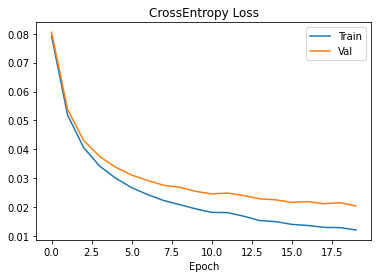

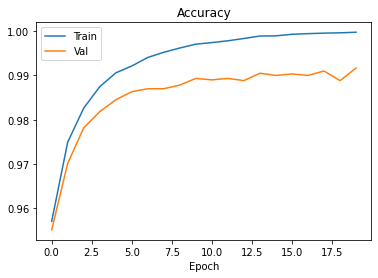

In [ ]:
best_model, best_val_accuracy, logger = train( lr=0.0001, nb_epochs=20, batch_size=64, seed=None)
# Saving the model 
checkpoint = {'capsule_model ' : best_model.state_dict() }
torch.save(checkpoint, "capsule_checkpoint.pth.tar" )
logger.plot_loss()
logger.plot_accuracy()
print(f"Best validation accuracy = {best_val_accuracy*100:.3f}")


In [ ]:

accuracy_test, loss_test = accuracy_and_loss_whole_dataset(64,data_loader_test, best_model)
print("Evaluation of the best training model over test set")
print("------")
print(f"Loss : {loss_test:.3f}")
print(f"Accuracy : {accuracy_test*100.:.3f}")

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Evaluation of the best training model over test set
------
Loss : 0.020
Accuracy : 99.200


In [ ]:
failed = failed_sample(best_model)


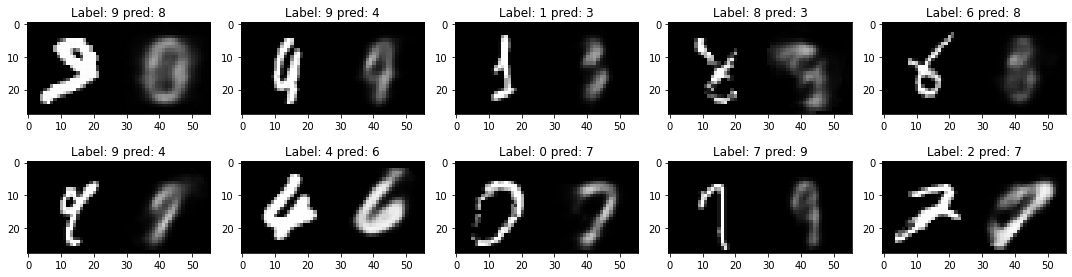

In [ ]:
plot_reconstructed(failed)

In [ ]:
success = success_sample(best_model)

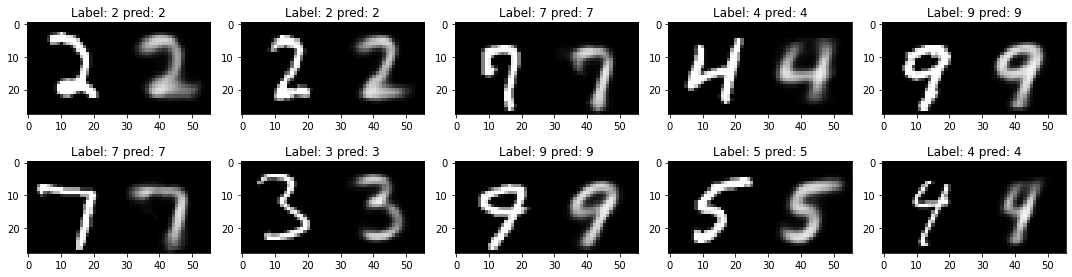

In [ ]:
plot_reconstructed(success)

In [ ]:
# The basline model (as is described in the paper )
class BaseLine (nn.Module):
    def __init__(self):
        super(BaseLine, self).__init__()
        self.conv_layers = nn.Sequential(
             nn.Conv2d(1 , 256, 5,stride =1, padding=0 ).to(device),
             nn.ReLU(),
             nn.Conv2d(256 , 256, 5, stride =1, padding=0 ).to(device),
             nn.ReLU(),
             nn.Conv2d(256 , 128, 5,stride =1, padding=0 ).to(device),
             nn.ReLU()


        )
        self.linear_layers =  nn.Sequential(
             nn.Linear(128*16*16,328 ).to(device),
             nn.ReLU(),
             nn.Linear(328, 192).to(device),
             nn.ReLU(),
             nn.Linear(192,10).to(device),
         
        )

    def forward(self, x):
        x = self.conv_layers(x).view(x.size()[0],-1)
        out = self.linear_layers(x)
        return out
    


In [ ]:
def train_baseLine( lr=0.01, nb_epochs=10, batch_size=64, seed=None):
    global model
    model = BaseLine()
    import torch.optim as optim
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_model = None
    global data_loader_test
    global data_loader_train
    data_loader_train, data_loader_val, data_loader_test = get_mnist_dataloaders(0.1, batch_size=batch_size)
    
    best_val_accuracy = 0
    logger = Logger()
    import time
    start_time = time.time()


    for epoch in range(nb_epochs):
        for batch_idx, (x, y) in enumerate(data_loader_train) :
            
            x=x.to(device=device)
            y= y.to(device=device)
            #y = torch.eye(10).index_select(dim=0, index=y).to(device)
            #y= torch.tensor(y, dtype=torch.long, device=device)
            y_pred = model(x)
            loss = criterion(y_pred,y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()         
            torch.cuda.empty_cache() 
        accuracy_train, loss_train = accuracy_and_loss_whole_dataset2(batch_size,data_loader_train, model)
        accuracy_val, loss_val = accuracy_and_loss_whole_dataset2(batch_size, data_loader_val, model)
        if accuracy_val  > best_val_accuracy: # select the best parameters based on the validation accuracy 
            best_model=copy.deepcopy(model)
            best_val_accuracy=accuracy_val
            pass  

        logger.log(accuracy_train, loss_train, accuracy_val, loss_val)
        if epoch % 1 == 0:
          print("--- %s seconds ---" % (time.time() - start_time))
          print(f"Epoch {epoch:2d}, \
                  Train:loss={loss_train.item():.4f}, accuracy={accuracy_train.item()*100:.4f}%, \
                  Val: loss={loss_val.item():.4f}, accuracy={accuracy_val.item()*100:.1f}%", flush=True)
        
    return best_model, best_val_accuracy, logger

--- 38.94760489463806 seconds ---
Epoch  0,                   Train:loss=0.0532, accuracy=98.3685%,                   Val: loss=0.0608, accuracy=98.0%
--- 80.7047049999237 seconds ---
Epoch  1,                   Train:loss=0.0352, accuracy=98.9018%,                   Val: loss=0.0449, accuracy=98.6%
--- 122.35503125190735 seconds ---
Epoch  2,                   Train:loss=0.0155, accuracy=99.5278%,                   Val: loss=0.0306, accuracy=99.1%
--- 163.83327960968018 seconds ---
Epoch  3,                   Train:loss=0.0216, accuracy=99.3278%,                   Val: loss=0.0400, accuracy=98.7%
--- 205.56536769866943 seconds ---
Epoch  4,                   Train:loss=0.0100, accuracy=99.6889%,                   Val: loss=0.0277, accuracy=99.2%
--- 246.92858123779297 seconds ---
Epoch  5,                   Train:loss=0.0101, accuracy=99.6889%,                   Val: loss=0.0325, accuracy=98.9%
--- 288.93321323394775 seconds ---
Epoch  6,                   Train:loss=0.0097, accuracy=

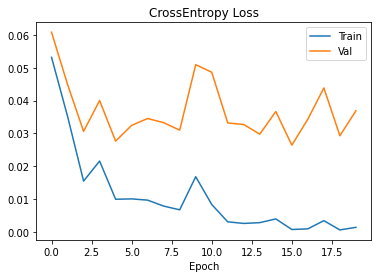

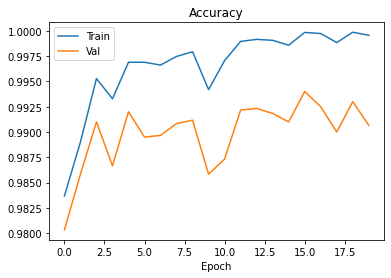

In [ ]:
best_model, best_val_accuracy, logger = train_baseLine( lr=0.0001, nb_epochs=20, batch_size=64, seed=None)


logger.plot_loss()
logger.plot_accuracy()
print(f"Best validation accuracy = {best_val_accuracy*100:.3f}")

In [ ]:

accuracy_test, loss_test = accuracy_and_loss_whole_dataset2(128,data_loader_test, best_model)
print("Evaluation of the best training model over test set")
print("------")
print(f"Loss : {loss_test:.3f}")
print(f"Accuracy : {accuracy_test*100.:.3f}")

Evaluation of the best training model over test set
------
Loss : 0.037
Accuracy : 99.150
